In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

In [3]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# Maximum iterations for iterative classification trainers
maxIter = 1000

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [4]:
# Used for plot names
est = "fraud_svc"
scoreText = "F1-Score"

In [5]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

# Use all features except time (omitting as I don't want to handle anything time-series related)
featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [6]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


# Initial Parameter Grid Search

In [7]:
Cs_rbf = np.geomspace(0.1, 1000, 5)
gammas_rbf = np.geomspace(0.00001, 0.1, 5)

Cs_linear = np.geomspace(0.0001, 10, 6)

paramGrid = [
    {
        'kernel': ['linear'],
        'C': Cs_linear,
    },
    {
        'kernel': ['rbf'],
        'C':Cs_rbf,
        'gamma': gammas_rbf,
    },
]

nData = -1 # (all)
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(SVC(random_state=randomSeed),
                  param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                  verbose=10, return_train_score=True, scoring='f1')

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 5245 data samples
Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:   22.8s finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061610,0.001152,0.011775,0.000748,0.0001,linear,NaN,"{'C': 0.0001, 'kernel': 'linear'}",0.521739,0.600000,...,0.591241,0.051318,27,0.614841,0.595745,0.575540,0.590747,0.605634,0.596501,0.013363
1,0.057641,0.010212,0.009173,0.001828,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.891304,0.898876,...,0.904222,0.024279,17,0.911111,0.900000,0.909091,0.890756,0.912088,0.904609,0.008142
2,0.063030,0.006256,0.006184,0.000399,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.903226,0.911111,...,0.911865,0.026114,8,0.914601,0.912568,0.912568,0.900552,0.920981,0.912254,0.006615
3,0.088763,0.005950,0.006583,0.000489,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.903226,0.913043,...,0.914975,0.026560,7,0.932615,0.915531,0.927224,0.921833,0.929730,0.925386,0.006070
4,0.206050,0.023613,0.006981,0.000627,1,linear,NaN,"{'C': 1.0, 'kernel': 'linear'}",0.903226,0.936170,...,0.922197,0.021571,2,0.932615,0.921833,0.927224,0.927614,0.932976,0.928452,0.004094
5,1.194206,0.286362,0.008777,0.000399,10,linear,NaN,"{'C': 10.0, 'kernel': 'linear'}",0.903226,0.936170,...,0.922197,0.021571,2,0.932615,0.921833,0.932976,0.933333,0.932976,0.930747,0.004463
6,0.227591,0.008014,0.059641,0.010878,0.1,rbf,1e-05,"{'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.274067,0.021273,0.060638,0.003535,0.1,rbf,0.0001,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.214826,0.004306,0.042685,0.001935,0.1,rbf,0.001,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.725000,0.775000,...,0.744838,0.044020,26,0.763407,0.742857,0.734824,0.742857,0.758621,0.748513,0.010727
9,0.197073,0.011504,0.038098,0.000977,0.1,rbf,0.01,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.879121,0.873563,...,0.884184,0.028567,18,0.892655,0.900000,0.891365,0.875000,0.903047,0.892413,0.009747


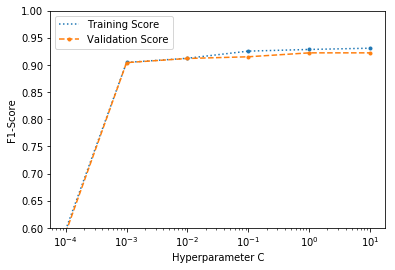

In [10]:
fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":", logx=True)
gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls="--", logx=True)
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Hyperparameter C")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_linear_gs")

Plots for rbf kernel (two hyperparameters)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b1154ba58>)

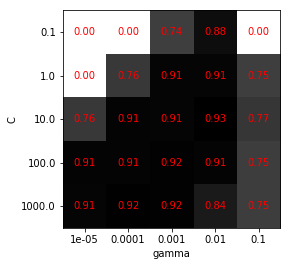

In [11]:
tempdf = gs_results_df.loc[gs_results_df.param_kernel == "rbf"]
toPlot = np.zeros((len(Cs_rbf), len(gammas_rbf)))
for i, hls in enumerate(Cs_rbf):
    for j, a in enumerate(gammas_rbf):
        k = i * len(gammas_rbf) + j
        toPlot[i, j] = tempdf.iloc[k].mean_test_score
heatmap(toPlot, gammas_rbf, Cs_rbf, xlabel="gamma", ylabel="C", savefig=est + pltNameSuffix + "_rbf_gs")

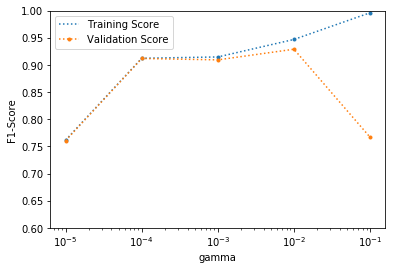

In [12]:
this_C = 10.0

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_C == this_C].plot(x='param_gamma', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":", logx=True)
gs_results_df.loc[gs_results_df.param_C == this_C].plot(x='param_gamma', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("gamma")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_Cslice")

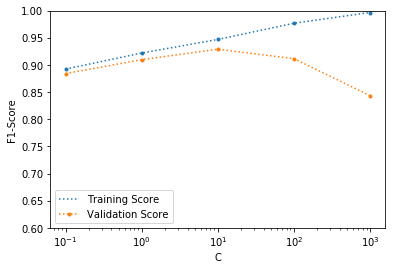

In [13]:
this_gamma = 0.01

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_gamma == this_gamma].plot(x='param_C', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":", logx=True)
gs_results_df.loc[gs_results_df.param_gamma == this_gamma].plot(x='param_C', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("C")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_Cslice")

In [14]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
yPred =  gs.best_estimator_.predict(X)
print(f'On the training data, we see precision and recall of:')
cr = classification_report(y, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)
print(f'but for the held-out test data we obtain just:')
yPred =  gs.best_estimator_.predict(XTest)
cr = classification_report(yTest, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)

From this, we choose the following parameters for computing the learning curve:
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
On the training data, we see precision and recall of:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00      5000
      Fraud       1.00      0.90      0.94       246

avg / total       1.00      1.00      0.99      5246

but for the held-out test data we obtain just:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00    120000
      Fraud       0.78      0.78      0.78       246

avg / total       1.00      1.00      1.00    120246



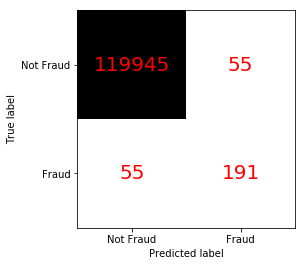

In [15]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

In [16]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(SVC(random_state=randomSeed, **lc_params), 
                          X, y, 
                          testSize = lcTestSize, scorer=f1_score, 
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                          randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Over 8 folds: [  31   67  146  316  500 1000 2000 3000]
Indices included at fold 0: 31
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 1: 67
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 2: 146
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 3: 316
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold 4: 500
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices

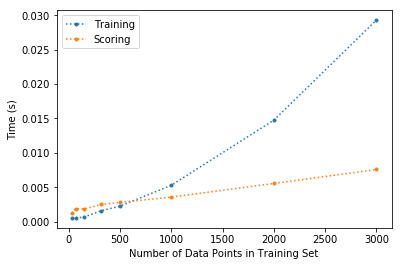

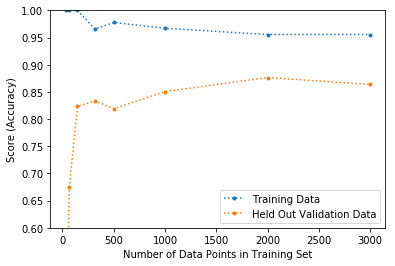

In [17]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [18]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.876 achieved with 2000 samples
